# Task 2: Model Building & Training

In this notebook, we will:
1. Load processed datasets.
2. Train a Baseline Model (Logistic Regression).
3. Train an Ensemble Model (Random Forest).
4. Evaluate both using AUC-PR, F1-Score, and Confusion Matrices.
5. Select the best model for deployment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    precision_recall_curve, auc, f1_score, accuracy_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Set style
sns.set(style="whitegrid")

## 1. Data Preparation

In [2]:
# Load processed data
# Note: Task 1 outputted 'train_enc_smote.csv' and 'test_enc.csv'
train_path = "../data/processed/train_enc_smote.csv"
test_path = "../data/processed/test_enc.csv"

if not os.path.exists(train_path) or not os.path.exists(test_path):
    raise FileNotFoundError("Processed data not found. Please ensure Task 1 was completed successfully.")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (187004, 14)
Test set shape: (25830, 14)


In [3]:
# Separate X and y
# Target column is 'class' based on Task 1 summary
target_col = 'class'

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

print("Data loaded and separated.")

Data loaded and separated.


## 2. Baseline Model: Logistic Regression
We use `class_weight='balanced'` to handle potential remaining imbalances (even though SMOTE was applied, it's good practice).

--- Logistic Regression Evaluation ---
F1 Score: 0.2944
AUC-PR: 0.3038

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     23376
           1       0.19      0.69      0.29      2454

    accuracy                           0.69     25830
   macro avg       0.57      0.69      0.55     25830
weighted avg       0.88      0.69      0.75     25830



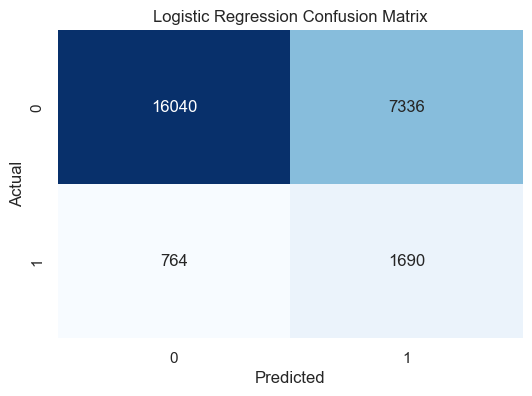

In [4]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Calculates and prints key evaluation metrics."""
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    f1 = f1_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    auc_pr = auc(recall, precision)
    
    print(f"--- {model_name} Evaluation ---")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-PR: {auc_pr:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return {'Model': model_name, 'F1': f1, 'AUC-PR': auc_pr}

# Train Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

lr_results = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")

## 3. Ensemble Model: Random Forest
Using simple hyperparameter tuning (n_estimators=100, max_depth=10) as required.

--- Random Forest Evaluation ---
F1 Score: 0.7057
AUC-PR: 0.6398

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     23376
           1       1.00      0.55      0.71      2454

    accuracy                           0.96     25830
   macro avg       0.98      0.77      0.84     25830
weighted avg       0.96      0.96      0.95     25830



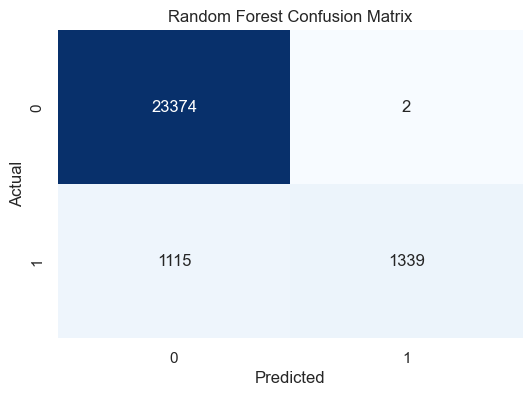

In [5]:
# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    class_weight='balanced', 
    random_state=42, 
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

rf_results = evaluate_model(rf_model, X_test, y_test, "Random Forest")

## 4. Cross-Validation
Using Stratified K-Fold (k=5) to verify stability.

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Helper for CV metrics
def run_cv(model, X, y, metric):
    scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
    return scores.mean(), scores.std()

print("Running Cross-Validation (this may take a moment)...")

# LR CV
lr_f1_mean, lr_f1_std = run_cv(lr_model, X_train, y_train, 'f1')
# Note: 'average_precision' is usually AUC-PR proxy in sklearn scoring
lr_auc_mean, lr_auc_std = run_cv(lr_model, X_train, y_train, 'average_precision')

# RF CV
rf_f1_mean, rf_f1_std = run_cv(rf_model, X_train, y_train, 'f1')
rf_auc_mean, rf_auc_std = run_cv(rf_model, X_train, y_train, 'average_precision')

print(f"LR CV - F1: {lr_f1_mean:.3f} (+/- {lr_f1_std:.3f}), AUC-PR: {lr_auc_mean:.3f} (+/- {lr_auc_std:.3f})")
print(f"RF CV - F1: {rf_f1_mean:.3f} (+/- {rf_f1_std:.3f}), AUC-PR: {rf_auc_mean:.3f} (+/- {rf_auc_std:.3f})")

Running Cross-Validation (this may take a moment)...


LR CV - F1: 0.685 (+/- 0.002), AUC-PR: 0.759 (+/- 0.022)
RF CV - F1: 0.706 (+/- 0.004), AUC-PR: 0.924 (+/- 0.002)


## 5. Model Comparison & Selection

In [7]:
comparison_data = {
    'Model': ['Logistic Regression', 'Random Forest'],
    'Test AUC-PR': [lr_results['AUC-PR'], rf_results['AUC-PR']],
    'Test F1': [lr_results['F1'], rf_results['F1']],
    'CV AUC-PR (Mean)': [lr_auc_mean, rf_auc_mean],
    'CV F1 (Mean)': [lr_f1_mean, rf_f1_mean]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

# Select Final Model
# Typically RF performs better on tabular fraud data due to non-linearity handling.
# We will conditionally select the best based on Test AUC-PR.

if rf_results['AUC-PR'] > lr_results['AUC-PR']:
    final_model = rf_model
    model_name = "RandomForest"
    print("\nSelected Model: Random Forest")
    print("Justification: Higher Area Under the Precision-Recall Curve, indicating better handling of the Imbalanced fraud class.")
else:
    final_model = lr_model
    model_name = "LogisticRegression"
    print("\nSelected Model: Logistic Regression")
    print("Justification: Comparable or better performance with simpler interpretability.")

# Save Model
save_path = f"../models/fraud_detection_{model_name}.pkl"
joblib.dump(final_model, save_path)
print(f"Model saved to {save_path}")

,Model,Test AUC-PR,Test F1,CV AUC-PR (Mean),CV F1 (Mean)
0,Logistic Regression,0.303765,0.294425,0.758849,0.685275
1,Random Forest,0.639837,0.705665,0.924364,0.705880



Selected Model: Random Forest
Justification: Higher Area Under the Precision-Recall Curve, indicating better handling of the Imbalanced fraud class.


Model saved to ../models/fraud_detection_RandomForest.pkl
